# Master video notebook!
This title might be a bit ambitious, but this notebook is supposed to be able to do all of the administration work when it comes to downloading, processing and analysing videos. The most important functions that will be called are stored in other python files, such that this notebook will remain legible. Analysis will be able to be done with a hierarchy structure of dataset, plate, video, hypha.

BEWARE:
When saving this document through a GitHub commit, make sure to clear all outputs. This document can easily go over the 100 MB size limit of GitHub files. 

### In MODULE one,
the Dropbox is scoured for information about videos. If the videos do not have a VideoInfo.txt, the program will look for a .csv, if there is no .csv, the program will look for a .xlsx file. Once these files have been found, all information will be merged into a pandas dataframe, and saved as a json file for the dataset and for each video. Some datasets contain thousands of videos, so scouring the dropbox for info on all of them is going to be an hours-long affair. Plan your analysis accordingly.

After scouring is complete, a final filtering step can be taken, whereupon the whole list of videos can be downloaded. NB: Downloading happens in two ways: videos are downloaded to the specified analysis folder, whereas video parameters and analysis will be downloaded to the specified analysis folder. This separation is done such that videos can be stored on larger storage drives, and analysis folders on faster storage drives.

(if Snellius is still used, it is recommended to use your scratch storage to store videos, and your home storage to store analysis. Scratch storage gets wiped every two weeks, but is much larger than home storage. )

TODO: Give options to download with SLURM job or manually.

### In MODULE two,
the downloaded videos with their respective information can be filtered, then analysed with a large SLURM job. In the future there might need to be functionality that allows processing without the use of a SLURM job. If you're reading this in 2024, you better apply for another Snellius grant!

### In MODULE three,
This is where all the bulk analysis is going to be. In high_mag_analysis.py, there are a number of classes and functions that will help you with parsing the data into meaningful graphs. This MODULE assumes the existence of the video_info.json files that are generated partly in MODULE 1.

### Below code:
Are just import statements

In [1]:
from IPython.display import clear_output
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import re
import dropbox
import sys
import pandas as pd
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
import logging
import datetime
import glob
import json
import scipy
import matplotlib as mpl

from subprocess import call
from tifffile import imwrite
from tqdm import tqdm
from pathlib import Path
from amftrack.util.dbx import (
    upload_folder,
    download,
    read_saved_dropbox_state,
    save_dropbox_state,
    load_dbx,
    get_dropbox_folders_prince,
    get_dropbox_video_folders,
    download_video_folders_drop,
    download_analysis_folders_drop,
)
from amftrack.pipeline.launching.run import (
    run_transfer,
)
from amftrack.pipeline.launching.run_super import run_parallel_transfer
from amftrack.pipeline.launching.run_super import run_parallel_flows
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plot_data import (
    plot_summary,
    save_raw_data,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_analysis import (
    HighmagDataset,
    VideoDataset,
    EdgeDataset,
    index_videos_dropbox_new,
    analysis_run,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.kymo_class import (
    KymoVideoAnalysis,
    KymoEdgeAnalysis,
)
from IPython.display import clear_output

%matplotlib widget
%load_ext autoreload
%autoreload 2
logging.basicConfig(stream=sys.stdout, level=logging.debug)
mpl.rcParams["figure.dpi"] = 200

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-06-17 15:25:00.988567: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 15:25:01.169603: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 15:25:01.567841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 15:25:18.974566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2024-06-17 15:26:43,782-[WARNING]- absl:256 -> Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2024-06-17 15:26:43,798-[WARNING]- absl:184 -> Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


/home/cbisot/miniconda3/envs/amftrack/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


## File declaration
As this notebook is designed to work with Snellius (now also on a local computer!), two items to separate are the raw video files and the analysis. The raw video files are large, bulky and not so easy to flip through. Ideally, the video files would be downloaded and the analysis would be stored on a separate folder structure entirely. That way, large scale analysis of analysis folders can happen when there are thousands of videos in the dataset, without having to have those raw video folders on hand.

Below function will basically make your folders fertile ground to accept all the video info folders and raw video files.

### Input:
Please give separately the folder where raw video data is stored, and where the analysis will be stored. Also give the dropbox address of the dataset you want to analyze.

### Output:
The specified dropbox folder will be looked through, and all relevant video information will be downloaded to an analysis folder structure identical to what is present on teh dropbox. The relevant raw video folder structure will also be generated, if specified so. Will also create cache files in the form of .json files such that next time, the scrounging does not have to happen.

In [2]:
# videos_folder = "F:\\AMOLF_Data\\videos\\"
# analysis_folder = "F:\\AMOLF_Data\\analysis\\"

# videos_folder = "/gpfs/scratch1/shared/amftrackflow/videos/"
# analysis_folder = "/gpfs/home6/svstaalduine/Analysis/"
videos_folder = "/projects/0/einf914/videos/"

analysis_folder = "/projects/0/einf914/analysis_videos/"
videos_folder = "/scratch-shared/amftrack/videos/"

analysis_folder = "/scratch-shared/amftrack/analysis_videos/"

In [3]:
# dropbox_address = "/DATA/FLUORESCENCE/DATA_NileRed/"
# dropbox_address=  "/DATA/MYRISTATE/DATA/2_weeks/"
# dropbox_address = "/DATA/TransportROOT/DATA/"
# dropbox_address = "/DATA/MYRISTATE/MorrisonDATA/20230508_Plate067/"
dropbox_address = "/DATA/MYRISTATE/MorrisonDATA/"
# dropbox_address = "/DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/"
# dropbox_address = "/DATA/Healing2024/"
# dropbox_address = "/DATA/TRANSPORT/DATA/20230308_Plate070/"

In [ ]:
dbx = load_dbx()

response = dbx.files_list_folder(dropbox_address, recursive=False)
names = [entry.name for entry in response.entries]

In [ ]:
names.index(name)

In [4]:
names = [
"20240319_Plate025",
"20240319_Plate027",
"20240319_Plate028",
"20240319_Plate035",
"20240319_Plate036",
"20240319_Plate037",

"20240422_Plate020",
"20240423_Plate016",
"20240423_Plate059",
"20240423_Plate063",
"20240423_Plate066",
"20240426_Plate045",
"20240426_Plate048",
"20240426_Plate052",
"20240426_Plate059",
"20240426_Plate063",
"20240426_Plate066",
"20240429_Plate059",
"20240429_Plate063",
"20240429_Plate066",
"20240430_Plate045",
"20240430_Plate048",
"20240430_Plate052",
"20240430_Plate066",

# "20240503_Plate045",
# "20240503_Plate048",
# "20240503_Plate053",
# "20240503_Plate059",
# "20240503_Plate062",
# "20240503_Plate063",
# "20240508_Plate045",
# "20240508_Plate048",
# "20240508_Plate053",
# "20240508_Plate059",
# "20240508_Plate062",
# "20240508_Plate068",
# "20240513_Plate023",
# "20240513_Plate029",
# "20240513_Plate040",
# "20240513_Plate059",
# "20240513_Plate062",
# "20240514_Plate030",
# "20240514_Plate038",
# "20240514_Plate039",
# "20240514_Plate045",
# "20240514_Plate053",
# "20240514_Plate068",
# "20240517_Plate042",
# "20240517_Plate053",
# "20240517_Plate054",
# "20240517_Plate059",
# "20240517_Plate062",
# "20240517_Plate065",
# "20240517_Plate081",
# "20240517_Plate086",
# "20240521_Plate042",
# "20240521_Plate053",
# "20240521_Plate054",
# "20240521_Plate059",
# "20240521_Plate062",
# "20240521_Plate065",
# "20240521_Plate084",
# "20240521_Plate087",
# "20240524_Plate042",
# "20240524_Plate053",
# "20240524_Plate054",
# "20240524_Plate062",
# "20240524_Plate065",
# "20240524_Plate081",
# "20240524_Plate084",
# "20240524_Plate086",
# "20240524_Plate087",
# "20240527_Plate060",
# "20240527_Plate065",
# "20240527_Plate084",
# "20240527_Plate087",
# "20240528_Plate041",
# "20240528_Plate042",
# "20240528_Plate054",
# "20240528_Plate060",
# "20240528_Plate062",
# "20240528_Plate080",
# "20240528_Plate081",
# "20240528_Plate086",
# "20240528_Plate088",
# "20240531_Plate041",
# "20240531_Plate042",
# "20240531_Plate060",
# "20240531_Plate062",
# "20240531_Plate065",
# "20240531_Plate080",
# "20240531_Plate088",
# "20240603_Plate041",
# "20240603_Plate042",
# "20240603_Plate060",
# "20240603_Plate065",
# "20240604_Plate042",
# "20240604_Plate065",
# "20240604_Plate078",
# "20240604_Plate079",
# "20240604_Plate080",
# "20240604_Plate088",
# "20240604_Plate089",
# "20240604_Plate090",
# "20240607_Plate042",
# "20240607_Plate060",
# "20240607_Plate078",
# "20240607_Plate079",
# "20240607_Plate080",
# "20240607_Plate088",
# "20240607_Plate089",
# "20240607_Plate090",
]

In [9]:
f"{dropbox_address}{name}/"

'/DATA/TransportROOT/DATA/20230522_926/'

In [5]:
for name in names:
    video_param_frame = index_videos_dropbox_new(
        analysis_folder,
        videos_folder,
        f"{dropbox_address}{name}/",
        REDO_SCROUNGING=True,
        # date_start=20230801,
        # date_end=20230813,
        plate_names=None,
    )
    download_frame = video_param_frame.copy()
    run_parallel_transfer(
        "from_drop_video.py",
        [videos_folder],
        download_frame,
        20,
        "24:00:00",
        "transfer_test",
    )
    clear_output(wait=False)

clear_output(wait=True)

Redoing the dropbox scrounging, hold on tight.
/DATA/MYRISTATE/MorrisonDATA/,20240430_Plate066
,20240430 Plate066
/DATA/MYRISTATE/MorrisonDATA/,20240430_Plate066
2024-06-11 09:40:36,703-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 09:40:36,899-[INFO]- dropbox:474 -> Request to files/list_folder


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/transport_processing/high_mag_videos/high_mag_analysis.py:134: SyntaxWarning: invalid escape sequence '\/'
  re.search("^.*Plate.*\/.*Plate\d{2,6}\..*$", entry, re.IGNORECASE)
/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/transport_processing/high_mag_videos/high_mag_analysis.py:1076: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("Velocity $(\mu m /s)$")
/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/transport_processing/high_mag_videos/high_mag_analysis.py:1545: SyntaxWarning: invalid escape sequence '\m'
  ax["kymo"].set_xlabel("x $(\mu m)$")
/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/transport_processing/high_mag_videos/high_mag_analysis.py:1556: SyntaxWarning: invalid escape sequence '\m'
  ax["spd_left"].set_xlabel("x $(\mu m)$")
/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/transport_processing/high_mag_videos/high_mag_analysis.py:1567

ApiError: ApiError('e332879fd84749c1b476d49257e1562e', ListFolderError('path', LookupError('not_found', None)))

In [ ]:
video_param_frame

In [5]:
video_param_frame = index_videos_dropbox_new(
    analysis_folder,
    videos_folder,
    dropbox_address,
    REDO_SCROUNGING=True,
    # date_start=20240319,
    # date_end=20240603,
    plate_names=None,
)
# clear_output(wait=False)

Redoing the dropbox scrounging, hold on tight.
/DATA/MYRISTATE/MorrisonDATA/20240319_Plate025
20240319 Plate025
/DATA/MYRISTATE/MorrisonDATA/20240319_Plate025
2024-06-11 13:14:13,847-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:14,109-[INFO]- dropbox:474 -> Request to files/list_folder
2024-06-11 13:14:14,466-[INFO]- dropbox:474 -> Request to files/get_metadata
2024-06-11 13:14:15,097-[INFO]- dropbox:474 -> Request to files/get_metadata
2024-06-11 13:14:15,501-[INFO]- dropbox:474 -> Request to files/get_metadata
2024-06-11 13:14:15,944-[INFO]- dropbox:474 -> Request to files/get_metadata
2024-06-11 13:14:16,404-[INFO]- dropbox:474 -> Request to files/get_metadata
2024-06-11 13:14:16,804-[INFO]- dropbox:474 -> Request to files/get_metadata
2024-06-11 13:14:17,195-[INFO]- dropbox:474 -> Request to files/get_metadata
2024-06-11 13:14:17,696-[INFO]- dropbox:474 -> Request to files/get_metadata
2024-06-11 13:14:18,237-[INFO]- dropbox:474 -> Request to files/get_metadata


  0%|                                                                                            | 0/40 [00:00<?, ?it/s]

2024-06-11 13:14:34,818-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:35,230-[INFO]- dropbox:474 -> Request to files/download


  2%|██                                                                                  | 1/40 [00:01<00:39,  1.02s/it]

2024-06-11 13:14:35,832-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:36,061-[INFO]- dropbox:474 -> Request to files/download


  5%|████▏                                                                               | 2/40 [00:01<00:33,  1.13it/s]

2024-06-11 13:14:36,629-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:36,824-[INFO]- dropbox:474 -> Request to files/download


  8%|██████▎                                                                             | 3/40 [00:02<00:35,  1.04it/s]

2024-06-11 13:14:37,693-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:37,887-[INFO]- dropbox:474 -> Request to files/download


 10%|████████▍                                                                           | 4/40 [00:03<00:32,  1.12it/s]

2024-06-11 13:14:38,472-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:38,672-[INFO]- dropbox:474 -> Request to files/download


 12%|██████████▌                                                                         | 5/40 [00:04<00:29,  1.18it/s]

2024-06-11 13:14:39,279-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:39,474-[INFO]- dropbox:474 -> Request to files/download


 15%|████████████▌                                                                       | 6/40 [00:05<00:27,  1.24it/s]

2024-06-11 13:14:40,036-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:40,231-[INFO]- dropbox:474 -> Request to files/download


 18%|██████████████▋                                                                     | 7/40 [00:05<00:27,  1.22it/s]

2024-06-11 13:14:40,825-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:41,042-[INFO]- dropbox:474 -> Request to files/download


 20%|████████████████▊                                                                   | 8/40 [00:06<00:25,  1.24it/s]

2024-06-11 13:14:41,617-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:41,801-[INFO]- dropbox:474 -> Request to files/download


 22%|██████████████████▉                                                                 | 9/40 [00:07<00:25,  1.20it/s]

2024-06-11 13:14:42,505-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:42,708-[INFO]- dropbox:474 -> Request to files/download


 25%|████████████████████▊                                                              | 10/40 [00:08<00:23,  1.27it/s]

2024-06-11 13:14:43,169-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:43,362-[INFO]- dropbox:474 -> Request to files/download


 28%|██████████████████████▊                                                            | 11/40 [00:09<00:23,  1.25it/s]

2024-06-11 13:14:43,996-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:44,188-[INFO]- dropbox:474 -> Request to files/download


 30%|████████████████████████▉                                                          | 12/40 [00:09<00:21,  1.30it/s]

2024-06-11 13:14:44,704-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:44,929-[INFO]- dropbox:474 -> Request to files/download


 32%|██████████████████████████▉                                                        | 13/40 [00:10<00:20,  1.33it/s]

2024-06-11 13:14:45,424-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:45,615-[INFO]- dropbox:474 -> Request to files/download


 35%|█████████████████████████████                                                      | 14/40 [00:11<00:20,  1.30it/s]

2024-06-11 13:14:46,233-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:46,482-[INFO]- dropbox:474 -> Request to files/download


 38%|███████████████████████████████▏                                                   | 15/40 [00:13<00:25,  1.03s/it]

2024-06-11 13:14:47,870-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:48,055-[INFO]- dropbox:474 -> Request to files/download


 40%|█████████████████████████████████▏                                                 | 16/40 [00:13<00:22,  1.07it/s]

2024-06-11 13:14:48,579-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:48,781-[INFO]- dropbox:474 -> Request to files/download


 42%|███████████████████████████████████▎                                               | 17/40 [00:15<00:25,  1.12s/it]

2024-06-11 13:14:50,108-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:50,306-[INFO]- dropbox:474 -> Request to files/download


 45%|█████████████████████████████████████▎                                             | 18/40 [00:16<00:23,  1.05s/it]

2024-06-11 13:14:51,028-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:51,230-[INFO]- dropbox:474 -> Request to files/download


 48%|███████████████████████████████████████▍                                           | 19/40 [00:16<00:20,  1.03it/s]

2024-06-11 13:14:51,786-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:51,969-[INFO]- dropbox:474 -> Request to files/download


 50%|█████████████████████████████████████████▌                                         | 20/40 [00:17<00:18,  1.09it/s]

2024-06-11 13:14:52,577-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:52,762-[INFO]- dropbox:474 -> Request to files/download


 52%|███████████████████████████████████████████▌                                       | 21/40 [00:18<00:16,  1.18it/s]

2024-06-11 13:14:53,259-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:53,441-[INFO]- dropbox:474 -> Request to files/download


 55%|█████████████████████████████████████████████▋                                     | 22/40 [00:19<00:14,  1.26it/s]

2024-06-11 13:14:53,936-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:54,131-[INFO]- dropbox:474 -> Request to files/download


 57%|███████████████████████████████████████████████▋                                   | 23/40 [00:19<00:13,  1.24it/s]

2024-06-11 13:14:54,759-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:54,943-[INFO]- dropbox:474 -> Request to files/download


 60%|█████████████████████████████████████████████████▊                                 | 24/40 [00:20<00:12,  1.32it/s]

2024-06-11 13:14:55,434-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:55,626-[INFO]- dropbox:474 -> Request to files/download


 62%|███████████████████████████████████████████████████▉                               | 25/40 [00:21<00:11,  1.31it/s]

2024-06-11 13:14:56,185-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:56,395-[INFO]- dropbox:474 -> Request to files/download


 65%|█████████████████████████████████████████████████████▉                             | 26/40 [00:22<00:10,  1.32it/s]

2024-06-11 13:14:56,920-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:57,093-[INFO]- dropbox:474 -> Request to files/download


 68%|████████████████████████████████████████████████████████                           | 27/40 [00:22<00:09,  1.39it/s]

2024-06-11 13:14:57,572-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:57,770-[INFO]- dropbox:474 -> Request to files/download


 70%|██████████████████████████████████████████████████████████                         | 28/40 [00:24<00:10,  1.13it/s]

2024-06-11 13:14:58,844-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:59,052-[INFO]- dropbox:474 -> Request to files/download


 72%|████████████████████████████████████████████████████████████▏                      | 29/40 [00:24<00:09,  1.18it/s]

2024-06-11 13:14:59,629-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:14:59,910-[INFO]- dropbox:474 -> Request to files/download


 75%|██████████████████████████████████████████████████████████████▎                    | 30/40 [00:25<00:08,  1.20it/s]

2024-06-11 13:15:00,516-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:00,699-[INFO]- dropbox:474 -> Request to files/download


 78%|████████████████████████████████████████████████████████████████▎                  | 31/40 [00:26<00:07,  1.22it/s]

2024-06-11 13:15:01,180-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:01,380-[INFO]- dropbox:474 -> Request to files/download


 80%|██████████████████████████████████████████████████████████████████▍                | 32/40 [00:27<00:06,  1.27it/s]

2024-06-11 13:15:01,940-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:02,128-[INFO]- dropbox:474 -> Request to files/download


 82%|████████████████████████████████████████████████████████████████████▍              | 33/40 [00:28<00:05,  1.19it/s]

2024-06-11 13:15:02,864-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:03,092-[INFO]- dropbox:474 -> Request to files/download


 85%|██████████████████████████████████████████████████████████████████████▌            | 34/40 [00:28<00:04,  1.22it/s]

2024-06-11 13:15:03,643-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:03,830-[INFO]- dropbox:474 -> Request to files/download


 88%|████████████████████████████████████████████████████████████████████████▋          | 35/40 [00:29<00:04,  1.22it/s]

2024-06-11 13:15:04,468-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:04,679-[INFO]- dropbox:474 -> Request to files/download


 90%|██████████████████████████████████████████████████████████████████████████▋        | 36/40 [00:30<00:03,  1.27it/s]

2024-06-11 13:15:05,173-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:05,381-[INFO]- dropbox:474 -> Request to files/download


 92%|████████████████████████████████████████████████████████████████████████████▊      | 37/40 [00:31<00:02,  1.24it/s]

2024-06-11 13:15:06,027-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:06,223-[INFO]- dropbox:474 -> Request to files/download


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 38/40 [00:32<00:01,  1.24it/s]

2024-06-11 13:15:06,847-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:07,032-[INFO]- dropbox:474 -> Request to files/download


 98%|████████████████████████████████████████████████████████████████████████████████▉  | 39/40 [00:32<00:00,  1.30it/s]

2024-06-11 13:15:07,516-[INFO]- dropbox:390 -> Refreshing access token.
2024-06-11 13:15:07,703-[INFO]- dropbox:474 -> Request to files/download


100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


All files downloaded! Merging files...


  0%|                                                                                            | 0/40 [00:00<?, ?it/s]/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/transport_processing/high_mag_videos/high_mag_analysis.py:289: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  raw_data["tot_path_drop"] = ["DATA/" + raw_data["tot_path"][0]]
/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/transport_processing/high_mag_videos/high_mag_analysis.py:289: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  raw_data["tot_path_drop"] = ["DATA/" + raw_data["tot_path"][0]]
/gpfs/home2/cbisot/pycode/AMFtra

## Where to go?
If you want to download videos:
Use MODULE 1

If you want to analyze already downloaded videos:
Skip MODULE 1, use MODULE 2

# MODULE 1: Downloading
This section, there is one block of code that will ask you one last time whether all of the parameters are correct. The block of code after that will initiate Snellius jobs to download the videos in the DataFrame from the dropbox. Downloading videos is not that costly, but of course we prefer it to be done as efficiently as possible.
## I'm not on Snellius! How do i download stuff??
Easy. Just skip the second block of code. The one below will just use the dropbox API to properly download all your raw data.
WARNING: This process can be quite long if you are queueing up a lot of videos. Do not use that block of code on Snellius, they will get mad at you (and prematurely stop your running program), just use the SLURM job in that case.

### Input:
Nothing
### Output:
Print statement with the DataFrame and the folders where everything will be stored.
Subsequent block of code will download raw video files to the videos folder.

In [7]:
video_param_frame.columns

Index(['imaging_day', 'storage_path', 'plate_id', 'root', 'strain',
       'treatment', 'crossing_day', 'video_int', 'time_(s)', 'mode',
       'exposure_time_(us)', 'fps', 'binning', 'gain', 'gamma', 'Fiber Led',
       'xpos', 'ypos', 'zpos', 'unique_id', 'folder', 'tot_path_drop',
       'record_time', 'days_after_crossing', 'magnification',
       'analysis_folder', 'videos_folder'],
      dtype='object')

In [8]:
#####################################################################################
### This is where you can apply the filters. Only those videos will be downloaded ###
#####################################################################################

download_frame = video_param_frame.copy()
# download_frame = download_frame[download_frame['mode'] == "F"]
# download_frame = download_frame[download_frame['plate_id']=="20230803_Plate999"]

#####################################################################################
### Below code will prepare for those videos to be downloaded into videos_folder  ###
#####################################################################################
print(f"Number of videos that will be downloaded: {len(download_frame)}")
download_frame.head(5)

Number of videos that will be downloaded: 40


,imaging_day,storage_path,plate_id,root,strain,treatment,crossing_day,video_int,time_(s),mode,...,ypos,zpos,unique_id,folder,tot_path_drop,record_time,days_after_crossing,magnification,analysis_folder,videos_folder
0,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,1,30.0,BF,...,13.971,23.605,20240319_Plate025_001,MYRISTATE/MorrisonDATA/20240319_Plate025/001/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:07:37,0,50.0,NaN,NaN
1,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,2,30.0,BF,...,14.449,23.686,20240319_Plate025_002,MYRISTATE/MorrisonDATA/20240319_Plate025/002/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:08:25,0,50.0,NaN,NaN
2,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,3,30.0,BF,...,4.585,23.922,20240319_Plate025_003,MYRISTATE/MorrisonDATA/20240319_Plate025/003/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:11:16,0,50.0,NaN,NaN
3,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,4,30.0,BF,...,4.585,23.926,20240319_Plate025_004,MYRISTATE/MorrisonDATA/20240319_Plate025/004/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:11:49,0,50.0,NaN,NaN
4,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,5,30.0,BF,...,5.918,23.838,20240319_Plate025_005,MYRISTATE/MorrisonDATA/20240319_Plate025/005/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:12:45,0,50.0,NaN,NaN


In [6]:
run_parallel_transfer(
    "from_drop_video.py",
    [videos_folder],
    download_frame,
    20,
    "24:00:00",
    "transfer_test",
)
clear_output(wait=False)

print(
    "Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress"
)

Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress


### Download videos from Dropbox (Not a SLURM job)
This block of code can be used to download videos individually from dropbox. 
Be aware:
- This is significantly slower than launching a SLURM job
- This downloads videos sequentially, not in parallel
- If this function is running for too long on Snellius, it might get you booted from the interactive node
- Videos are large. Make sure you have the space.

In [ ]:
download_video_folders_drop(download_frame, videos_folder)
clear_output(wait=False)
print("All videos downloaded!")

### Download Analysis folders from Dropbox (not a SLURM job)
Similar warnings apply as the video download function above. The file sizes for the analysis folders are, however, vastly smaller than video files. This allows for a bit more wiggle room.

In [ ]:
download_analysis_folders_drop(analysis_folder, dropbox_address)
clear_output(wait=False)
print("All analysis folders downloaded!")

# Module 2: Processing

Now that the files have been downloaded, it's time to analyse them. In the below code, you'll be able to either do a complete survey of the analysis folder for as many videos as possible, or use the DataFrame of recently downloaded videos to filter for the videos you want to analyse.

Also possible to analyse videos directly in this notebook. Be aware again that this is a sequential, and slower analysis than running a SLURM job. 

### Input:
DataFrame filters of all videos to be analysed
### Output:
Print statements for all parameters of the analysis session that is about to take place.

In [5]:
folder_filter = dropbox_address[5:]

img_infos = glob.glob(
    f"{analysis_folder}{folder_filter}/**/video_data.json", recursive=True
)
vid_anls_frame = pd.DataFrame()
for address in img_infos:
    add_info = pd.read_json(address, orient="index").T
    vid_anls_frame = pd.concat([vid_anls_frame, add_info], ignore_index=True)

vid_anls_frame = vid_anls_frame.sort_values("unique_id").reset_index(drop=True)
# vid_anls_frame.tail(20)

In [6]:
def remove_last_section(id_string):
    # Check if the string is actually a string and contains an underscore
    if isinstance(id_string, str) and '_' in id_string:
        # Split on the last underscore and return the first part
        return id_string.rsplit('_', 1)[0]
    else:
        # Return the original string if it doesn't meet the criteria
        return id_string

# Apply this function to each element in the 'unique_id' column
vid_anls_frame['modified_id'] = vid_anls_frame['unique_id'].apply(remove_last_section)


In [10]:
vid_anls_frame

,imaging_day,storage_path,plate_id,root,strain,treatment,crossing_day,video_int,time_(s),mode,...,ypos,zpos,unique_id,folder,tot_path_drop,record_time,days_after_crossing,magnification,analysis_folder,videos_folder
0,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,1,30.0,BF,...,13.971,23.605,20240319_Plate025_001,MYRISTATE/MorrisonDATA/20240319_Plate025/001/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:07:37,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...
1,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,2,30.0,BF,...,14.449,23.686,20240319_Plate025_002,MYRISTATE/MorrisonDATA/20240319_Plate025/002/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:08:25,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...
2,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,3,30.0,BF,...,4.585,23.922,20240319_Plate025_003,MYRISTATE/MorrisonDATA/20240319_Plate025/003/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:11:16,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...
3,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,4,30.0,BF,...,4.585,23.926,20240319_Plate025_004,MYRISTATE/MorrisonDATA/20240319_Plate025/004/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:11:49,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...
4,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,5,30.0,BF,...,5.918,23.838,20240319_Plate025_005,MYRISTATE/MorrisonDATA/20240319_Plate025/005/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:12:45,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...
5,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,6,30.0,BF,...,5.918,23.842,20240319_Plate025_006,MYRISTATE/MorrisonDATA/20240319_Plate025/006/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:13:20,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...
6,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,7,30.0,BF,...,7.567,23.855,20240319_Plate025_007,MYRISTATE/MorrisonDATA/20240319_Plate025/007/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:14:17,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...
7,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,8,30.0,BF,...,3.36,23.86,20240319_Plate025_008,MYRISTATE/MorrisonDATA/20240319_Plate025/008/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:17:04,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...
8,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,9,30.0,BF,...,4.726,23.891,20240319_Plate025_009,MYRISTATE/MorrisonDATA/20240319_Plate025/009/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:17:58,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...
9,20240319,Dropbox\DATA\MYRISTATE\MorrisonDATA,20240319_Plate25,None,A5,0.5Myristate,20240319,10,30.0,BF,...,4.726,23.894,20240319_Plate025_010,MYRISTATE/MorrisonDATA/20240319_Plate025/010/Img,DATA/MYRISTATE/MorrisonDATA/20240319_Plate025/...,16:18:31,0,50.0,/scratch-shared/amftrack/analysis_videos/MYRIS...,/scratch-shared/amftrack/videos/MYRISTATE/Morr...


In [7]:
####################################################################################
### This is where you can apply the filters. Only those videos will be analyzed. ###
####################################################################################

# analysis_frame = vid_anls_frame[
#     vid_anls_frame["imaging_day"].ge("20230814")
# ].reset_index(drop=True)
# analysis_frame = vid_anls_frame[vid_anls_frame['xpos'].le(100)].reset_index(drop=True)
# analysis_frame = analysis_frame[analysis_frame['mode']=="F"]
# analysis_frame = vid_anls_frame[vid_anls_frame['modified_id'].isin(names)]
# analysis_frame = analysis_frame[analysis_frame['video_int'].isin([1])]
analysis_frame = vid_anls_frame

####################################################################################
### Below code will prepare for those videos to be downloaded to videos_folder.  ###
####################################################################################

print(f"Number of videos to be analyzed: {len(analysis_frame)}")
# analysis_frame.tail(20)

Number of videos to be analyzed: 796


In [7]:
analysis_frame = analysis_frame.loc[0:1500]

## Run SLURM Analysis job
Two options: For small analysis, use the first block. This will just do the calculations on the machine. For large-scale analysis, use the second block, as it will create a Snellius job.
## Input:
Snellius job parameters
## Output:
Analysis folder will be populated with analysis tiffs and csv sheets. At the same time, this analysis folder will also be uploaded to the dropbox.

In [8]:
### LARGE VIDEO ANALYSIS

nr_parallel = np.min([len(analysis_frame.index), 100])

run_parallel_flows(
    "flux_extract.py",
    [analysis_folder, 9, 0.95, 0.005, 200, dropbox_address],
    analysis_frame,
    nr_parallel,
    "2:00:00",
    "flux_extract",
    name_job="flux_extract.sh",
    node = "fat_rome"
)
clear_output(wait=False)

print(
    "Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress"
)

Sent all the jobs! Use the command '$ squeue' in the terminal to see the progress


In [8]:
nr_parallel = np.min([len(analysis_frame.index), 40])

run_parallel_transfer(
    "flux_upload.py",
    [analysis_folder, 9, 0.95, 0.005, 200, dropbox_address],
    analysis_frame,
    nr_parallel,
    "6:00:00",
    "flux_upload",
    node="staging",
    cpus=1,
    # dependency = "flux_extract.sh",
    name_job="flux_upload.sh",
)
clear_output(wait=False)

In [7]:
from memory_profiler import profile
%load_ext memory_profiler

In [45]:
import gc
gc.collect()

407

In [8]:
%memit KymoVideoAnalysis(input_frame=analysis_frame.iloc[20], logging=True, samepos_frame=pd.DataFrame())

Data input succesful! Starting edge extraction...
segmenting
lenvideo 600
Successfully extracted the skeleton. Did you know there is a skeleton inside inside you right now?
peak memory: 908.91 MiB, increment: 337.35 MiB


In [12]:
edge_objs = test_video.edge_objects
edge = edge_objs[0]
%memit edge.extract_multi_kymo(1, target_length=120, kymo_adj=False, kymo_normalize=True)


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:58<00:00, 58.48s/it]

peak memory: 620.41 MiB, increment: 23.52 MiB


In [13]:
%memit edge.fourier_kymo(return_self=False)


peak memory: 657.00 MiB, increment: 71.46 MiB


In [14]:
%memit edge.extract_speeds(w_size=9,w_start=3,C_thresh_falloff=0.005,blur_size = 3,C_thresh = 0.95,speed_thresh = 5)


peak memory: 611.21 MiB, increment: 25.56 MiB


In [11]:
test_video = KymoVideoAnalysis(input_frame=analysis_frame.iloc[20], logging=True, samepos_frame=pd.DataFrame())

Data input succesful! Starting edge extraction...
segmenting
lenvideo 600
Successfully extracted the skeleton. Did you know there is a skeleton inside inside you right now?


In [13]:
import gc
def incremental_mean_std_address(image_addresses):
    n = len(image_addresses)
    sum_images = None
    sum_sq_diff = None

    for address in image_addresses:
        image = imageio.imread(address)
        if sum_images is None:
            sum_images = np.zeros_like(image, dtype=np.float32)
            sum_sq_diff = np.zeros_like(image, dtype=np.float32)

        sum_images += image
        del image  # Suggest deletion of the image variable
        gc.collect()
    mean_image = sum_images / n

    for address in image_addresses:
        image = imageio.imread(address)
        sq_diff = (image - mean_image) ** 2
        sum_sq_diff += sq_diff
        del image  # Suggest deletion of the image variable
        gc.collect()

    variance_image = sum_sq_diff / n
    std_dev_image = np.sqrt(variance_image)

    return mean_image, std_dev_image

In [12]:
addresses = test_video.selection_file[:300]

In [37]:
incremental_mean_std(addresses)[1]-np.std(images,axis=0)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
images = [imageio.imread(addresses) for addresses in test_video.selection_file[:10]]


In [26]:
%memit np.std(images,axis= 0)

peak memory: 12698.41 MiB, increment: 10640.64 MiB


In [14]:
%memit incremental_mean_std_address(addresses)

peak memory: 839.24 MiB, increment: 245.88 MiB


In [55]:
result = incremental_mean_std_address(addresses)

In [56]:
getsize(result)/1e6

98.304312

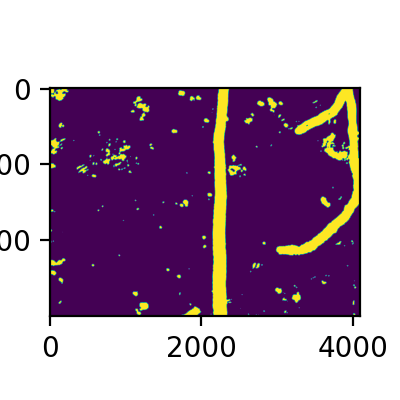

In [23]:
plt.close("all")
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(test_video.segmented)
# test_video.segmented.shape

In [13]:
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [44]:
getsize(test_video)/1e6

20.07906

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(segmented, alpha=1)

In [ ]:
imgs_address

In [10]:
imgs_address = Path(analysis_frame.iloc[9]["videos_folder"])
images_total_path = [str(adr) for adr in imgs_address.glob("*_*.ti*")]
images_total_path.sort()
[imageio.imread(addresses) for addresses in images_total_path[:10]]

[array([[ 90,  90,  88, ...,  86,  90,  88],
        [ 91,  90,  89, ...,  89,  89,  86],
        [ 88,  90,  89, ...,  90,  87,  89],
        ...,
        [ 88,  87,  83, ..., 121, 126, 117],
        [ 82,  85,  88, ..., 122, 118, 116],
        [ 83,  86,  86, ..., 115, 114, 111]], dtype=uint8),
 array([[ 91,  89,  89, ...,  87,  88,  91],
        [ 90,  90,  89, ...,  87,  87,  85],
        [ 91,  90,  89, ...,  87,  88,  90],
        ...,
        [ 87,  86,  84, ..., 126, 125, 120],
        [ 84,  84,  85, ..., 124, 118, 116],
        [ 84,  86,  83, ..., 114, 116, 113]], dtype=uint8),
 array([[ 91,  94,  94, ...,  87,  89,  90],
        [ 89,  90,  90, ...,  87,  90,  90],
        [ 89,  92,  89, ...,  90,  90,  90],
        ...,
        [ 85,  85,  86, ..., 126, 119, 121],
        [ 85,  85,  85, ..., 123, 119, 115],
        [ 86,  84,  84, ..., 112, 116, 111]], dtype=uint8),
 array([[ 90,  90,  91, ...,  85,  87,  88],
        [ 88,  90,  90, ...,  87,  87,  89],
        [ 91,  8

In [ ]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.high_mag_videos_fun import *

segmented, _, _ = segment_fluo_new(
    [imageio.imread(addresses) for addresses in test_video.selection_file[:30]],
    threshtype="hist_edge",
)

In [11]:
images = [imageio.imread(addresses) for addresses in test_video.selection_file[:30]]
std_image = np.mean(images, axis=0)
smooth_im_blur = cv2.blur(std_image, (20, 20))

In [ ]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.hist(smooth_im_blur.flatten(), 20)

In [ ]:
thresh = find_histogram_edge(smooth_im_blur)
seg_thresh = 1.10
segmented = (smooth_im_blur >= thresh * seg_thresh).astype(np.uint8) * 255

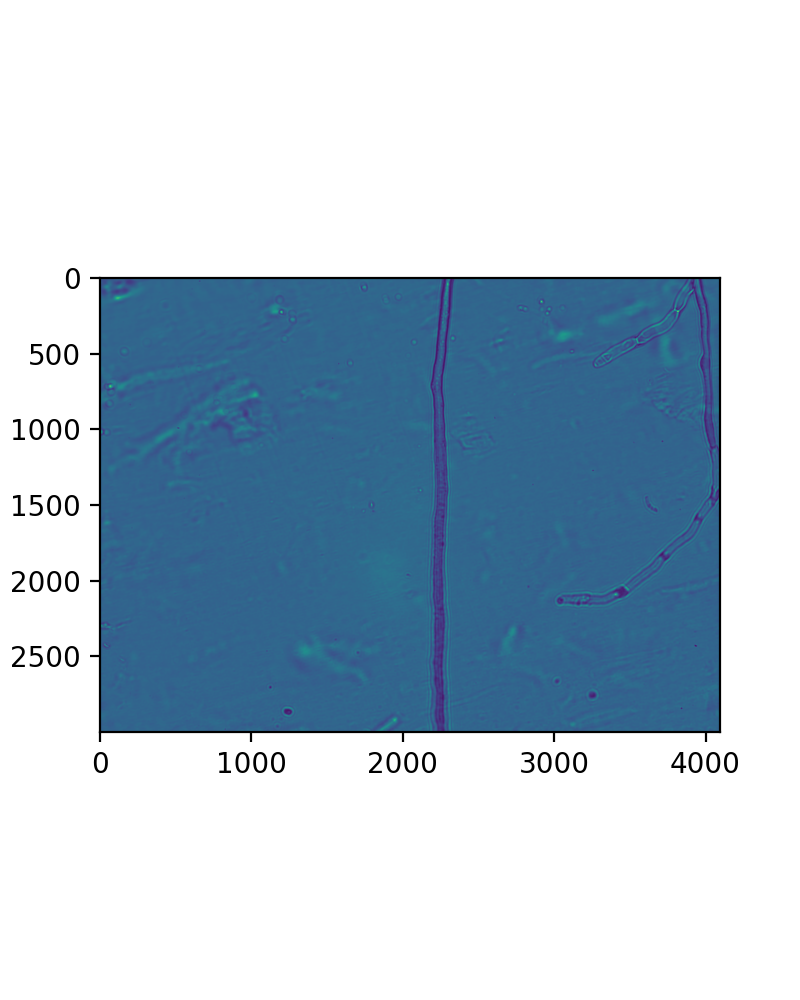

In [12]:
plt.close("all")
fig, ax = plt.subplots(figsize=(4, 5))
ax.imshow(images[0])
# ax.imshow(segmented, alpha=0.2)

## Run local analysis
This is code where you can run a specialized analysis on a limited number of videos. This uses the same analysis frame which you use to filter videos for the SLURM jobs.

First the analysis function is defined, which you can change to fit the parameters you want. Then the next block of code will use that function to go through each row in the video analyis dataframe and executes the analysis. NOTE: This is not code to go through the analysis, that is for MODULE 3.


In [ ]:
edges_objs = analysis_run(
    analysis_frame.iloc[:4],
    analysis_folder,
    videos_folder,
    dropbox_address,
    logging=True,  # Print progress to console
    kymo_normalize=True,  # Normalize the kymograph for visual representation
    kymo_section_width=1.8,  # Width of kymograph lines, adjusted for magnification
    thresh_adjust=0,  # Adjustment for thresholding the frangi filter. Will be added to Otsu threshold.
    frangi_range=np.arange(10, 120, 20),  # Range of distances in pixels to expect hyp
    close_size=200,  # Size of kernel to use in closing operation after thresholding frangi filter
    edge_len_min=40,  # Minimum edge length to select for
    save_edge_extraction_plot=True,  # Save picture of extracted edges
    make_video=False,  # Make mp4 of raw data TIFFs
    create_snapshot=True,  # Save image of edge
    create_edge_video=False,  # Save video of edge
    photobleach_adjust=False,  # Adjust kymograph for photobleaching
    speed_ext_window_number=9,  # Size range to investigate speeds
    speed_ext_window_start=3,  # Start size of window for GST
    speed_ext_c_thresh=0.95,  # Confidence threshold for speed determination
    speed_ext_c_falloff=0.005,  # Confidence falloff as window size increases
    speed_ext_blur_size=1,  # Kymograph blur Gaussian kernel size
    speed_ext_blur=True,  # Whether to preblur at all
    speed_ext_max_thresh=80,  # Maximum expected speeds (in um/s)
    dropbox_upload=False,  # Whether to upload results to dropbox
    fourier_radius=30,  # From what pixel radius to include the fourier spectrum during fourier analysis
    fourier_prominence=1,  # Prominence metric for finding peaks in fourier analysis
)

In [ ]:
# for edge_group in edges_objs:
#     print(edge_group)
# print(np.array(edges_objs).flatten())
small_data_obj = HighmagDataset(analysis_frame, analysis_folder, videos_folder)

In [ ]:
for edge in small_data_obj.edge_objs:
    edge.show_summary()

### Width profile Kymograph analysis
This is going to be some special code to extract multiple kymographs from the same edge, all next to each other. Requires running the previous code to get the analysis objects.

In [ ]:
print([[edge.edge_name for edge in edge_list] for edge_list in edges_objs])
edge_interest = edges_objs[0][0]

width_len = 4
# TODO: Get effective mean speed calculation in here too

kymos = edge_interest.extract_multi_kymo(width_len, target_length=70)
fourier_kymos = edge_interest.fourier_kymo()
speeds, times = edge_interest.extract_speeds(15)

In [ ]:
print(np.array(times).shape)
speed_max = 20
fig, ax = plt.subplots(width_len)
for i in range(width_len):
    ax[i].plot(times[i], np.nanmean(speeds[i][0], axis=1))
    ax[i].plot(times[i], np.nanmean(speeds[i][1], axis=1))
    ax[i].fill_between(
        times[i],
        np.nanmean(speeds[i][0], axis=1) + np.nanstd(speeds[i][0], axis=1),
        np.nanmean(speeds[i][0], axis=1) - np.nanstd(speeds[i][0], axis=1),
        alpha=0.5,
        facecolor="tab:blue",
    )
    ax[i].fill_between(
        times[i],
        np.nanmean(speeds[i][1], axis=1) + np.nanstd(speeds[i][1], axis=1),
        np.nanmean(speeds[i][1], axis=1) - np.nanstd(speeds[i][1], axis=1),
        alpha=0.5,
        facecolor="tab:orange",
    )
    ax[i].set_ylim((-speed_max, speed_max))

fig, ax = plt.subplots()
for i in range(1, width_len):
    ax.set_title("Speeds along the width")
    ax.scatter(
        i, np.mean(np.nanmean(speeds[i][0], axis=1)), c="tab:blue", label="to tip"
    )
    ax.errorbar(
        i,
        np.mean(np.nanmean(speeds[i][0], axis=1)),
        np.nanstd(speeds[i][0].flatten()),
        capsize=5,
        c="tab:blue",
    )
    ax.scatter(
        i, np.mean(np.nanmean(speeds[i][1], axis=1)), c="tab:orange", label="to root"
    )
    ax.errorbar(
        i,
        np.mean(np.nanmean(speeds[i][1], axis=1)),
        np.nanstd(speeds[i][1].flatten()),
        capsize=5,
        c="tab:orange",
    )
    ax.set_ylim([-15, 15])
    ax.set_xlabel("Width fraction nr")
    ax.set_ylabel("Velocity $(\mu m /s)$")
    ax.grid(True)

In [ ]:
for i in range(len(kymos)):
    fig, ax = plt.subplots()
    ax.imshow(kymos[i])

# Module 3: Bulk Analysis
## First part: Assemble Edge DataFrame


In this initial part of the bulk analysis, all of the analysis folders will be looked through to find the edge data we're looking for. Additionally, there is an optional part to download the analysis folder back to the analysis folder we specified right at the top.

## Assuming all the analysis folders are already downloaded:
You can use below code to read the video_data.json files that are created during indexing of all the videos

In [ ]:
folder_filter = dropbox_address[5:]

img_infos = glob.glob(
    f"{analysis_folder}{folder_filter}/**/video_data.json", recursive=True
)
vid_anls_frame = pd.DataFrame()
for address in tqdm(img_infos):
    add_info = pd.read_json(address, orient="index").T
    vid_anls_frame = pd.concat([vid_anls_frame, add_info], ignore_index=True)

vid_frame = vid_anls_frame.sort_values("unique_id").reset_index(drop=True)

In [ ]:
####################################################################################
### This is where you can apply the filters. Only those videos will be analyzed. ###
####################################################################################

# analysis_frame = vid_frame[vid_frame['imaging_day'].le(20230725)].reset_index(drop=True)
analysis_frame = vid_frame

analysis_frame["plate_int"] = [
    entry.split("_")[-1] for entry in analysis_frame["plate_id"]
]
analysis_frame["video_int"] = [
    entry.split("_")[-1] for entry in analysis_frame["unique_id"]
]

# analysis_frame = analysis_frame[analysis_frame['plate_int'] != "Plate440"].reset_index(drop=True)
analysis_frame = analysis_frame[
    analysis_frame["imaging_day"].ge("20230810")
].reset_index(drop=True)
analysis_frame = analysis_frame[analysis_frame["xpos"].le(100)].reset_index(drop=True)

### Run below to update analysis and videos folder entries if you've downloaded the analysis
analysis_frame["analysis_folder"] = [
    str((Path(analysis_folder) / entry["folder"]).parent)
    for index, entry in analysis_frame.iterrows()
]
analysis_frame["videos_folder"] = [
    str(Path(videos_folder) / entry["folder"])
    for index, entry in analysis_frame.iterrows()
]

####################################################################################
### Below code will prepare for those videos to be downloaded to videos_folder.  ###
####################################################################################
analysis_frame

In [ ]:
data_obj = HighmagDataset(analysis_frame, analysis_folder, videos_folder)

In [ ]:
plt.close("all")

### Example code for plotting fraction bar graphs


In [ ]:
speed_ranges = [
    edge.time_data["speed_weight_mean"].quantile(0.95)
    - edge.time_data["speed_weight_mean"].quantile(0.05)
    for edge in data_obj.edge_objs
]
data_obj.edges_frame["speed_range"] = speed_ranges
data_int_obj = data_obj.filter_edges("coverage_tot", ">=", 0.5)
speed_linear_rachael = data_int_obj.filter_edges("speed_range", "<=", 2.0)
speed_bulk_rachael = data_int_obj.filter_edges("speed_range", ">=", 2.0)
print(len(speed_linear_rachael.edges_frame))
print(len(speed_bulk_rachael.edges_frame))

In [ ]:
print(speed_bulk_rachael.edges_frame["unique_id"].unique())

In [ ]:
N = 3
linear = (676, 899, 3671)
bulk = (689, 190, 230)
vid_sums = np.add(linear, bulk)
linear = np.divide(linear, vid_sums)
bulk = bulk / vid_sums
linear

fig, ax = plt.subplots()
ax.bar(
    np.arange(N), linear, 0.3, label="$\overline{v}_{.95} - \overline{v}_{.05} < 2.0$"
)
ax.bar(
    np.arange(N),
    bulk,
    0.3,
    bottom=linear.T,
    label="$\overline{v}_{.95} - \overline{v}_{.05} > 2.0$",
)
ax.set_xticks(
    np.arange(N),
    (
        f"Lid Off 1 (n={vid_sums[0]})",
        f"Lid Off 2 (n={vid_sums[1]})",
        f"Lid On (n={vid_sums[2]})",
    ),
)
ax.set_title("Linear / Bulk flow partitions using speed range")
ax.set_ylabel("Fraction")
ax.legend()

### Example code for creating different plate maps
Below you can see the filtering options for different plates and the plot_plate_locs function that outputs a map with dots or arrows depending on your wishes. Current drawing modes are:
- 'scatter' for dots of the videos, separated by magnification
- 'speeds_mean' for black arrows denoting the effective mean speed of the flows
- 'speeds_both' for blue and orange arrows denoting the effective speed of flows in both directions
- 'vid_labels'  for a list of what videos were taken at each position

In [ ]:
speed_ranges = [
    edge.time_data["speed_weight_mean"].quantile(0.95)
    - edge.time_data["speed_weight_mean"].quantile(0.05)
    for edge in data_obj.edge_objs
]
data_obj.edges_frame["speed_ranges"] = speed_ranges

In [ ]:
fig, ax = plt.subplots()
ax.hist(speed_ranges, bins=50)

In [ ]:
plt.close("all")
mpl.rcParams["figure.dpi"] = 500
print(data_obj.video_frame.columns)

for plate_id in tqdm(data_obj.video_frame["plate_id"].unique()):
    plate_group = data_obj.filter_edges("coverage_tot", ">=", 0.3)
    plate_group = plate_group.filter_edges("plate_id", "==", plate_id)
    #     plate_group = plate_group.filter_edges('mode', '==', "BF")
    plate_group = plate_group.filter_edges("speed_ranges", ">=", 3.0)
    if len(plate_group.video_frame) <= 1:
        continue
    else:
        plate_group.plot_plate_locs(
            analysis_folder, spd_thresh=0.5, modes=["speeds_both"]
        )

mpl.rcParams["figure.dpi"] = 200

### Example code 50x speed arrows

In [ ]:
plt.close("all")
data_interest = data_obj.filter_edges("video_int", ">=", "071")
data_interest = data_interest.filter_edges("video_int", "<=", "080")
data_interest = data_interest.filter_edges("mode", "==", "BF")
data_interest = data_interest.filter_edges("imaging_day", "==", "20230810")

for vid_obj in data_interest.video_objs:
    vid_obj.plot_speed_arrows(plot_both=True, save_im=True, video_txt_size=30)

# for edge in data_interest.edge_objs:
#     edge.direction_filter()

### Example code plot summaries of videos


In [ ]:
plt.close("all")

data_obj_filt = data_obj.filter_edges("video_int", ">=", "000")
data_obj_filt = data_obj_filt.filter_edges("video_int", ">=", "001")
data_obj_filt = data_obj_filt.filter_edges("video_int", "<=", "003")
data_obj_filt = data_obj_filt.filter_edges("coverage_tot", ">=", 0.5)
data_obj_filt = data_obj_filt.filter_edges("speed_range", ">=", 1.5)
# data_obj_filt = data_obj_filt.filter_edges('coverage_left', '<=', 0.3)
# data_obj_filt = data_obj_filt.filter_edges('coverage_right', '<=', 0.3)

# print(len(data_oj))
for edge in data_obj_filt.edge_objs:
    #     video.show_segmentation()
    edge.show_summary()

### Example code binned violin-plot
bin-column represents the value to be binned, then multiple violin plots are graphed on the same axis.

In [ ]:
cover_filter_data = data_obj.filter_edges("coverage_tot", ">=", 0.5)
filter_BF = cover_filter_data.filter_edges("mode", "==", "BF")
filter_BF = filter_BF.filter_edges("imaging_day", ">=", "20230814")
# filter_BF = cover_filter_data
bin_column = "ypos"

# bins = np.linspace(5, 15, 10)
bins = np.linspace(
    filter_BF.return_edge_frame()[bin_column].min(),
    filter_BF.return_edge_frame()[bin_column].max(),
    20,
)
bin_series = filter_BF.bin_values(bin_column, bins)
# print(bin_series)

labels = []
fig, ax = filter_BF.plot_violins("speed_right", bins, c="tab:orange", labels=labels)
fig, ax = filter_BF.plot_violins(
    "speed_left", bins, c="tab:blue", ax=ax, fig=fig, labels=labels
)
fig, ax = filter_BF.plot_violins(
    "speed_mean", bins, c="tab:red", ax=ax, fig=fig, labels=labels
)

ax.axhline(c="black", alpha=0.5, linestyle="--")
ax.set_ylabel("v $(\mu m / s)$")
ax.set_xlabel("hyphal width $(\mu m)$")
ax.legend(*zip(*labels))

### Example code for bin-less violin plots
This can be for comparing videos, plates, anything with a unique ID

In [ ]:
cover_filter_data = data_obj.filter_edges("coverage_tot", ">=", 0.5)
cover_filter_data = cover_filter_data.filter_edges("plate_int", "<=", "Plate449")

filter_BF = cover_filter_data

labels = []
fig, ax = filter_BF.plot_violins(
    "speed_right", bin_separator="plate_id", c="tab:orange", labels=labels
)
fig, ax = filter_BF.plot_violins(
    "speed_left", bin_separator="plate_id", c="tab:blue", ax=ax, fig=fig, labels=labels
)
fig, ax = filter_BF.plot_violins(
    "speed_mean", bin_separator="plate_id", c="tab:red", ax=ax, fig=fig, labels=labels
)

ax.axhline(c="black", alpha=0.5, linestyle="--")
ax.set_ylabel("v $(\mu m / s)$")
ax.set_xlabel("Plate id's")
ax.legend(*zip(*labels))
fig.tight_layout()

In [ ]:
print(data_obj.video_frame["video_int"].to_string())

### Example code on visualizing 4x/50x comparisons

In [ ]:
data_4x_filter = data_obj.filter_edges("magnification", "==", 4.0)
mag_corr_groups = [
    data_obj.context_4x(row) for index, row in data_4x_filter.video_frame.iterrows()
]
for group in tqdm(mag_corr_groups):
    group.plot_4x_locs(analysis_folder)

In [ ]:
plt.close("all")

spd_maxes_BF = []
spd_maxes_BF_440 = []
spd_maxes_BF_441 = []
spd_maxes_BF_449 = []
spd_maxes_BF_414 = []
flux_avgs_BF = []
spd_maxes_FL = []
flux_avgs_FL = []

print(data_obj.video_frame["plate_int"].unique())

# linear_edges = data_obj.filter_edges('plate_int',  '==', 'Plate440')
# linear_edges = data_obj.filter_edges('imaging_day',  '>=', '20230728')
# linear_edges = linear_edges.filter_edges('imaging_day',  '<=', '20230727')
linear_edges = data_obj.filter_edges("coverage_left", ">=", 0.45)
linear_edges = linear_edges.filter_edges("coverage_right", ">=", 0.45)
# linear_edges = linear_edges.filter_edges('mode',  '==', 'BF')
# linear_edges_440 = linear_edges.filter_edges('plate_int',  '==', 'Plate440')
# linear_edges_441 = linear_edges.filter_edges('plate_int',  '==', 'Plate441')
# linear_edges_449 = linear_edges.filter_edges('plate_int',  '==', 'Plate449')
# linear_edges_414 = linear_edges.filter_edges('plate_int',  '==', 'Plate414')
linear_edges_BF = linear_edges.filter_edges("mode", "==", "BF")
linear_edges_FL = linear_edges.filter_edges("mode", "==", "F")

for edge in tqdm(linear_edges_BF.edge_objs):
    spd_maxes_BF.append(
        edge.plot_speed_histo(
            spd_extent=10,
            spd_tiff_lowbound=0.5,
            spd_cutoff=0.5,
            bin_res=1000,
            plot_fig=False,
        )
    )
    flux_avgs_BF.append(edge.time_data["flux_mean"].mean())
# for edge in tqdm(linear_edges_440.edge_objs):
#     spd_maxes_BF_440.append(edge.plot_speed_histo(spd_extent=10, spd_tiff_lowbound=0.0, spd_cutoff = 0.0, bin_res=1000, plot_fig=False))
# for edge in tqdm(linear_edges_441.edge_objs):
#     spd_maxes_BF_441.append(edge.plot_speed_histo(spd_extent=10, spd_tiff_lowbound=0.0, spd_cutoff = 0.0, bin_res=1000, plot_fig=False))
# for edge in tqdm(linear_edges_449.edge_objs):
#     spd_maxes_BF_449.append(edge.plot_speed_histo(spd_extent=10, spd_tiff_lowbound=0.0, spd_cutoff = 0.0, bin_res=1000, plot_fig=False))
# for edge in tqdm(linear_edges_414.edge_objs):
#     spd_maxes_BF_414.append(edge.plot_speed_histo(spd_extent=10, spd_tiff_lowbound=0.0, spd_cutoff = 0.0, bin_res=1000, plot_fig=False))
for edge in tqdm(linear_edges_FL.edge_objs):
    spd_maxes_FL.append(
        edge.plot_speed_histo(
            spd_extent=10,
            spd_tiff_lowbound=0.5,
            spd_cutoff=0.5,
            bin_res=1000,
            plot_fig=False,
        )
    )
    flux_avgs_FL.append(edge.time_data["flux_mean"].mean())

In [ ]:
print(linear_edges_BF.edges_frame["unique_id"].to_string())
print(linear_edges_FL.edges_frame["unique_id"].to_string())

In [ ]:
spd_maxes_BF = np.array(spd_maxes_BF)
spd_maxes_FL = np.array(spd_maxes_FL)
spd_maxes_BF_440 = np.array(spd_maxes_BF_440)
spd_maxes_BF_441 = np.array(spd_maxes_BF_441)
spd_maxes_BF_449 = np.array(spd_maxes_BF_449)
spd_maxes_BF_414 = np.array(spd_maxes_BF_414)

colors = ["tab:orange", "tab:blue", "tab:green", "tab:red", "tab:purple"]

video_bins = [[0, 500]]

fig, ax = plt.subplots(2, figsize=(10, 10))

for i, bins in enumerate(video_bins):
    ax[0].scatter(
        -linear_edges_BF.edges_frame["ypos"].astype(float),
        spd_maxes_BF.T[1],
        marker="s",
        c=colors[i],
        alpha=0.7,
        label=f"to tip, hypha {i+1}",
    )
    ax[0].scatter(
        -linear_edges_BF.edges_frame["ypos"].astype(float),
        spd_maxes_BF.T[0],
        marker="o",
        c=colors[i],
        alpha=0.7,
        label=f"to root, hypha {i+1}",
    )
#     ax[0].scatter(-linear_edges_BF.edges_frame['ypos'].astype(float)[bins[0]:bins[1]], np.array(flux_avgs_BF[bins[0]:bins[1]]), marker='P',c=colors[i+1], alpha=0.7, label=f'flux, hypha {i+1}')
for i, bins in enumerate(video_bins):
    ax[1].scatter(
        -linear_edges_FL.edges_frame["ypos"].astype(float),
        spd_maxes_FL.T[1],
        marker="s",
        c=colors[i + 1],
        alpha=0.7,
        label=f"to tip, hypha {i+1}",
    )
    ax[1].scatter(
        -linear_edges_FL.edges_frame["ypos"].astype(float),
        spd_maxes_FL.T[0],
        marker="o",
        c=colors[i + 1],
        alpha=0.7,
        label=f"to root, hypha {i+1}",
    )
#     ax[1].scatter(-linear_edges_FL.edges_frame['ypos'].astype(float)[bins[0]:bins[1]], np.array(flux_avgs_FL[bins[0]:bins[1]]), marker='P',c=colors[i+2], alpha=0.7, label=f'flux, hypha {i+1}')

for j in range(2):
    ax[j].grid(True)
    ax[j].set_ylabel("Measured speed $(\mu m /s)$")
    ax[j].set_xlabel("y-position (root to tip)")
    ax[j].set_title("Speeds along a single hypha")
    ax[j].set_ylim([-10, 10])
    ax[j].axhline(c="black")
    ax[j].legend()
    fig.tight_layout()
# print(linear_edges.edges_frame['video_int'].to_string())

In [ ]:
fig, ax = plt.subplots()
ax.hist(flux_avgs_BF, density=True, alpha=0.6, bins=40, range=[-350, 350], label="BF")
ax.hist(flux_avgs_FL, density=True, alpha=0.6, bins=40, range=[-350, 350], label="FL")
ax.axvline()
ax.legend()

fig, ax = plt.subplots()
ax.hist(
    spd_maxes_BF.T[0],
    alpha=0.6,
    density=True,
    bins=80,
    range=[-5, 5],
    color="tab:orange",
    label="Bright-field, n=674",
)
ax.hist(
    spd_maxes_BF.T[1],
    alpha=0.6,
    density=True,
    bins=80,
    range=[-5, 5],
    color="tab:orange",
)
ax.hist(
    spd_maxes_FL.T[0],
    alpha=0.6,
    density=True,
    bins=80,
    range=[-5, 5],
    color="tab:blue",
    label="Fluorescence, n=388",
)
ax.hist(
    spd_maxes_FL.T[1], alpha=0.6, density=True, bins=80, range=[-5, 5], color="tab:blue"
)
ax.set_xlabel("Velocity $(\mu m / s)$")
ax.set_ylabel("Frequency")
ax.set_title("Speed profiles lid On")
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux (to root --> to tip)")
ax.legend()

### Plot for a beautiful butterfly

In [ ]:
# spd_maxes_BF = np.array(spd_maxes_BF)
# spd_maxes_FL = np.array(spd_maxes_FL)

colors = ["tab:orange", "tab:blue", "tab:green", "tab:red", "tab:purple"]
titles = ["Plate 440", "Plate 441", "Plate 449", "Plate 414", "tab:purple"]

video_bins = [[0, 500]]

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

for i, bins in enumerate(video_bins):
    ax[0][0].scatter(
        -spd_maxes_BF_440.T[0],
        spd_maxes_BF_440.T[1],
        marker="s",
        c=colors[i],
        alpha=0.2,
        label=f"Brightfield",
    )
    ax[0][1].scatter(
        -spd_maxes_BF_441.T[0],
        spd_maxes_BF_441.T[1],
        marker="s",
        c=colors[i],
        alpha=0.2,
        label=f"Brightfield",
    )
    ax[1][0].scatter(
        -spd_maxes_BF_449.T[0],
        spd_maxes_BF_449.T[1],
        marker="s",
        c=colors[i],
        alpha=0.2,
        label=f"Brightfield",
    )
    ax[1][1].scatter(
        -spd_maxes_BF_414.T[0],
        spd_maxes_BF_414.T[1],
        marker="s",
        c=colors[i],
        alpha=0.2,
        label=f"Brightfield",
    )
#     ax[1].scatter(-spd_maxes_FL.T[0][bins[0]:bins[1]], spd_maxes_FL.T[1][bins[0]:bins[1]], marker='s',c=colors[i+1], alpha=0.2, label=f'Fluorescence')

for i, axis in enumerate(ax.flatten()):
    axis.grid(True)
    axis.set_ylabel("Speed $(\mu m /s)$ towards Tip")
    axis.set_xlabel("Speed $(\mu m /s)$ towards Root")
    axis.set_title(f"{titles[i]}")
    axis.set_aspect("equal")
    axis.set_ylim([0, 10])
    axis.set_xlim([0, 10])
#     axis.legend()
fig.tight_layout()
# print(linear_edges.edges_frame['video_int'].to_string())